In [24]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:
final_df = pd.read_csv(r"C:\Users\kotag\OneDrive\Desktop\Documents\GitHub\AI-PriceOptima\final\baseline_pricing_output.csv")
final_df.head()


,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride,Location_Category_Suburban,Location_Category_Urban,Customer_Loyalty_Status_Regular,Customer_Loyalty_Status_Silver,Time_of_Booking_Evening,Time_of_Booking_Morning,Time_of_Booking_Night,Vehicle_Type_Premium,Demand_Ratio,Baseline_Price,Baseline_Revenue,Revenue_Lift
0,90,45,13,4.47,90,284.257273,False,True,False,True,False,False,True,True,1.956522,398.221368,398.221368,0.400919
1,58,39,72,4.06,43,173.874753,True,False,False,True,True,False,False,False,1.450000,398.221368,398.221368,1.290277
2,42,31,0,3.99,76,329.795469,False,False,False,True,False,False,False,True,1.312500,398.221368,398.221368,0.207480
3,89,28,67,4.31,134,470.201232,False,False,True,False,False,False,False,True,3.068966,398.221368,398.221368,-0.153083
4,78,22,74,3.77,149,579.681422,False,False,True,False,False,False,False,False,3.391304,398.221368,398.221368,-0.313034


 Reconstruct Categorical Features

In [27]:
# Time of Booking (from one-hot encoded columns)
def get_time(row):
    if row['Time_of_Booking_Morning'] == 1:
        return 'Morning'
    elif row['Time_of_Booking_Evening'] == 1:
        return 'Evening'
    elif row['Time_of_Booking_Night'] == 1:
        return 'Night'
    else:
        return 'Unknown'

final_df['Time_of_Booking'] = final_df.apply(get_time, axis=1)

# Vehicle Type (from binary column)
final_df['Vehicle_Type'] = final_df['Vehicle_Type_Premium'].apply(lambda x: 'Premium' if x == 1 else 'Standard')


Time-Based Pricing Rule

In [9]:
def time_based_price(row):
    base = row['Baseline_Price']
    if row['Time_of_Booking'] == 'Morning':
        adj = 0.95
    elif row['Time_of_Booking'] == 'Evening':
        adj = 1.10
    elif row['Time_of_Booking'] == 'Night':
        adj = 1.05
    else:
        adj = 1.00
    return round(base * adj, 2)

final_df['Time_Based_Price'] = final_df.apply(time_based_price, axis=1)


Inventory-Based Pricing Rule

In [ ]:
final_df['Supply_Demand_Ratio'] = final_df['Number_of_Drivers'] / (final_df['Number_of_Riders'] + 1)

def inventory_based_price(row):
    base = row['Baseline_Price']
    ratio = row['Supply_Demand_Ratio']
    if ratio < 0.5:
        adj = 1.20
    elif ratio < 1.0:
        adj = 1.10
    elif ratio < 2.0:
        adj = 1.00
    else:
        adj = 0.90
    return round(base * adj, 2)

final_df['Inventory_Based_Price'] = final_df.apply(inventory_based_price, axis=1)


 Simulate Revenue and Lift

In [11]:
# Revenue = Price × Demand Ratio
final_df['Time_Based_Revenue'] = (final_df['Time_Based_Price'] * final_df['Demand_Ratio']).round(2)
final_df['Inventory_Based_Revenue'] = (final_df['Inventory_Based_Price'] * final_df['Demand_Ratio']).round(2)

# Revenue Lift = New Revenue - Baseline Revenue
final_df['Time_Revenue_Lift'] = (final_df['Time_Based_Revenue'] - final_df['Baseline_Revenue']).round(2)
final_df['Inventory_Revenue_Lift'] = (final_df['Inventory_Based_Revenue'] - final_df['Baseline_Revenue']).round(2)


Evaluate Performance

In [12]:
print("Average Revenue Lift (Time-Based): ₹", final_df['Time_Revenue_Lift'].mean().round(2))
print("Average Revenue Lift (Inventory-Based): ₹", final_df['Inventory_Revenue_Lift'].mean().round(2))


Average Revenue Lift (Time-Based): ₹ 815.73
Average Revenue Lift (Inventory-Based): ₹ 1000.81


Visualize Baseline vs Historical Pricing

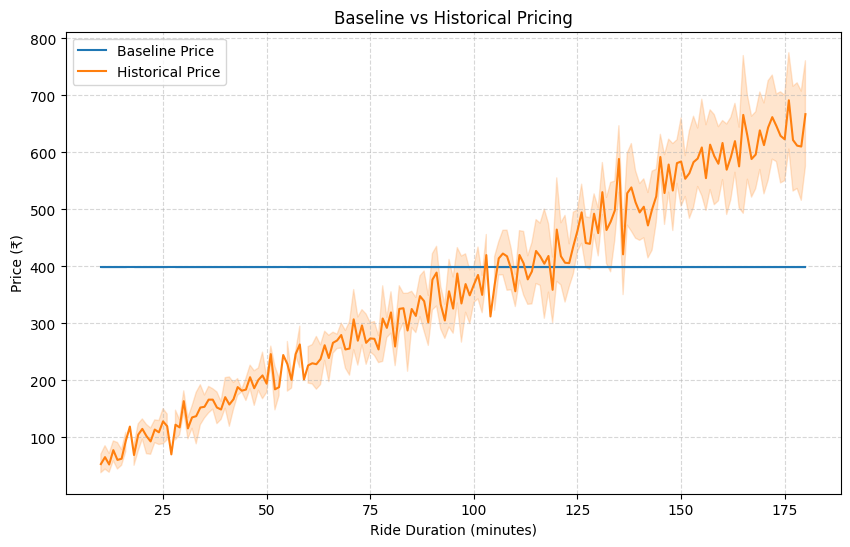

In [26]:
final_df_sorted = final_df.sort_values(by='Expected_Ride_Duration')

plt.figure(figsize=(10, 6))
sns.set_palette(['#1f77b4', '#ff7f0e'])

sns.lineplot(x='Expected_Ride_Duration', y='Baseline_Price', data=final_df_sorted, label='Baseline Price')
sns.lineplot(x='Expected_Ride_Duration', y='Historical_Cost_of_Ride', data=final_df_sorted, label='Historical Price')

plt.title('Baseline vs Historical Pricing')
plt.xlabel('Ride Duration (minutes)')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


This graph compares our fixed baseline pricing with historical ride costs. The baseline price stays constant at around ₹400 regardless of ride duration, while historical prices increase with longer rides and show variability. This highlights the limitations of static pricing and the potential benefits of dynamic strategies.